# Supervised data compression via linear discriminant analysis

Linear Discriminant Analysis (LDA) can be used as a technique for feature extraction to increase the computational efficiency and reduce the degree of overfitting due to the curse of dimensionality in non-regularized models.

Whereas PCA attempts to find the orthogonal component axes of maximum variance in a dataset, the goal in LDA is to find the feature subspace that optimizes class separability.

## Principal component analysis versus linear discriminant analysis

The aim of both is to reduce the number of dimensions in a dataset, PCA is an unsupervised algorithm whereas LDA is supervised. We might think that LDA is superior, however PCA tends to result in better classification results in an image recognition task in certain cases.

The following figure summarizes the concept of LDA for a two-class problem.

<img src="images/lda_concept.jpeg" alt="PCA orthogonal axes" title="PCA orthogonal axes" height="300" width="450">

A linear discriminant, as shown on the x-axis (LD 1), would separate the two normal distributed classes well. Although the exemplary linear discriminant shown on the y-axis (LD 2) captures a lot of the variance in the dataset, it would fail as a good linear discriminant since it does not capture any of the class-discriminatory information.

One assumption in LDA is that the data is normally distributed. Also, we assume that the classes have identical covariance matrices and that the samples are statistically independent of each other. However, even if one or more of those assumptions are (slightly) violated, LDA for dimensionality reduction can still work reasonably well 

### The inner working

Before we dive into the code implementation, let's briefly summarize the main steps that are required to perform LDA:

1. Standardize the $d$-dimensional dataset ($d$ is the number of features).
2. For each class, compute the $d$-dimensional mean vector.
3. Construct the between-class scatter matrix $S_B$ and the within-class scatter matrix $S_w$. 
4. Compute the eigenvectors and corresponding eigenvalues of the matrix $S_w^{-1} S_B$.
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
6. Choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues to construct a $d \times k$-dimensional transformation matrix $W$; the eigenvectors are the columns of this matrix.
7. Project the samples onto the new feature subspace using the transformation matrix $W$.

#### Computing the scatter matrices

After load and standardized the features, proceed with the calculation of the mean vectors, which we will use to construct the within-class scatter matrix and between-class scatter matrix, respectively. Each mean vector $m_i$ stores the mean feature value $\mu_m$ with respect to the samples of class **i**:

\begin{equation*}
m_i = \frac{1}{n_i} \sum_{x \in D_i}^c x_m
\end{equation*}

This results in three mean vectors:

\begin{equation*}
\begin{matrix}
m_i = \begin{bmatrix}
\mu_i, alcohol \\
\mu_i, \text{malic acid} \\
\vdots \\
\mu_i, proline
\end{bmatrix} & i \in \left\{ 1, 2, 3 \right\} \\
\end{matrix}
\end{equation*}

In [3]:
# load data
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)   # 
# online
# df = pd.read_csv('./data_sets/wine.data', header=None)    # offline

In [4]:
# separate training and test data (70, 30)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
import numpy as np


np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV {}: {}\n'.format(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Using the mean vectors, we can now compute the within-class scatter matrix $S_w$:

\begin{equation*}
S_w = \sum_{i=1}^c S_i
\end{equation*}

This is calculated by summing up the individual scatter matrices $S_i$ of each individual class $i$:

\begin{equation*}
S_i = \sum_{x \in D_i}^c \left( x - m_i \right) \left( x - m_i \right)^T
\end{equation*}

In [4]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
    
print('Within-class scatter matrix: {}x{}'.format(S_W.shape[0], S_W.shape[1]))
S_W

Within-class scatter matrix: 13x13


array([[ 5.0722e+01,  3.1007e+00, -7.9323e+00, -5.7848e+00, -2.8879e+00,
         7.8990e+00,  2.4543e+00,  9.3932e-01,  9.0781e-01,  1.5486e+01,
         7.0293e+00, -1.8659e+00,  4.9370e+00],
       [ 3.1007e+00,  9.0179e+01,  4.7074e+00,  1.4750e+01, -1.0900e+01,
        -8.8059e-02,  9.7797e-01,  8.4547e+00,  4.4732e+00, -1.4494e+01,
        -2.0361e+01,  3.5876e+00, -1.1176e+01],
       [-7.9323e+00,  4.7074e+00,  1.1189e+02,  7.0126e+01,  2.2213e+01,
         1.5505e+01,  1.4856e+01,  2.0454e+01, -2.3344e+00,  1.3787e+00,
         5.6585e+00,  8.1917e+00,  3.2570e-01],
       [-5.7848e+00,  1.4750e+01,  7.0126e+01,  9.2147e+01,  1.2485e+01,
         6.2091e+00,  6.2783e+00,  1.2735e+01, -4.7597e+00, -4.1511e+00,
         1.1779e+00,  1.1633e+01, -4.5296e+00],
       [-2.8879e+00, -1.0900e+01,  2.2213e+01,  1.2485e+01,  1.0605e+02,
         1.0950e+01,  5.2875e+00, -2.1136e+01,  1.3076e+01,  5.9930e+00,
         8.4568e+00, -5.3128e-01,  1.1845e+01],
       [ 7.8990e+00, -8.8059e-

The assumption that we are making when we are computing the scatter matrices is that the class labels in the training set are uniformly distributed. However, if we print the number of class labels, we see that this assumption is violated:

In [5]:
print('Class label distribution: {}'.format(np.bincount(y_train)[1:]))

Class label distribution: [41 50 33]


Thus, we want to scale the individual scatter matrices $S_i$ before we sum them up as scatter matrix $S_w$. When we divide the scatter matrices by the number of class-samples $n_i$, we can see that computing the scatter matrix is in fact the same as computing the covariance matrix $\Sigma_i$ —the covariance matrix is a normalized version of the scatter matrix:

\begin{equation*}
\Sigma_i = \frac{1}{n_i}S_w = \frac{1}{n_i} \sum_{x \in D_i}^c \left( x - m_i \right) \left( x - m_i \right)^T
\end{equation*}

In [6]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print('Within-class scatter matrix: {}x{}'.format(S_W.shape[0], S_W.shape[1]))
S_W

Within-class scatter matrix: 13x13


array([[ 1.2448,  0.0967, -0.1276, -0.1105, -0.0726,  0.2374,  0.0753,
         0.0231,  0.1102,  0.4261,  0.1411, -0.0155,  0.1224],
       [ 0.0967,  2.2666,  0.1168,  0.3517, -0.2622, -0.0467, -0.0186,
         0.2194,  0.0187, -0.3939, -0.4167,  0.0787, -0.2492],
       [-0.1276,  0.1168,  2.6024,  1.6442,  0.5364,  0.3947,  0.3191,
         0.4553, -0.0353,  0.06  ,  0.167 ,  0.1987, -0.0081],
       [-0.1105,  0.3517,  1.6442,  2.1604,  0.325 ,  0.1535,  0.1222,
         0.273 , -0.0824, -0.068 ,  0.0336,  0.2548, -0.1201],
       [-0.0726, -0.2622,  0.5364,  0.325 ,  2.4397,  0.2384,  0.1433,
        -0.5166,  0.2566,  0.1445,  0.1777, -0.0058,  0.2509],
       [ 0.2374, -0.0467,  0.3947,  0.1535,  0.2384,  1.352 ,  0.6416,
        -0.0781,  0.7644,  0.4392,  0.0177,  0.4359,  0.1554],
       [ 0.0753, -0.0186,  0.3191,  0.1222,  0.1433,  0.6416,  0.6968,
        -0.2588,  0.5765,  0.3851, -0.0408,  0.2525,  0.0748],
       [ 0.0231,  0.2194,  0.4553,  0.273 , -0.5166, -0.0781, 

After we computed the scaled within-class scatter matrix (or covariance matrix), we can move on to the next step and compute the between-class scatter matrix $S_B$:

\begin{equation*}
S_B = \sum_{i=1}^c n_i \left( m_i - m \right) \left( m_i - m \right)^T
\end{equation*}

Here, $m$ is the overall mean that is computed, including samples from all classes:

In [13]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)   # make column vector
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: {}x{}'.format(S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


## Selecting linear discriminants for the new feature subspace

The remaining steps of the LDA are similar to the steps of the PCA. However, instead of performing the eigendecomposition on the covariance matrix, we solve the generalized eigenvalue problem of the matrix $S_w^{-1} S_B$:

In [14]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [15]:
# sort the eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in descending orde:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending orde:

349.617808905994
172.76152218979396
3.757738185175197e-14
3.757738185175197e-14
2.842170943040401e-14
1.891112347433115e-14
1.891112347433115e-14
1.1127858294960469e-14
1.1127858294960469e-14
6.78305538162405e-15
5.3244850056953785e-15
5.3244850056953785e-15
1.8570370341745825e-15


In LDA, the number of linear discriminants is at most $c−1$, where c is the number of class labels, since the in-between scatter matrix $S_B$ is the sum of c matrices with rank 1 or less. We can indeed see that we only have two nonzero eigenvalues (the eigenvalues 3-14 are not exactly zero, but this is due to the floating point arithmetic in NumPy).

To measure how much of the class-discriminatory information is captured by the linear discriminants (eigenvectors), let's plot the linear discriminants by decreasing eigenvalues similar to the explained variance plot that we created in the PCA section.

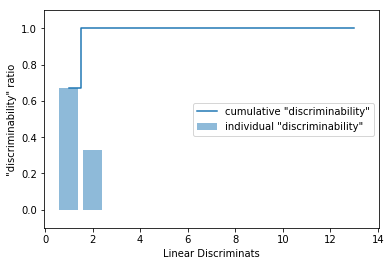

In [17]:
import matplotlib.pyplot as plt


tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminats')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

Let's now stack the two most discriminative eigenvector columns to create the transformation matrix $W$:

In [18]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


## Projecting samples onto the new feature space

Using the transformation matrix $W$ that we created in the previous subsection, we can now transform the training dataset by multiplying the matrices:

\begin{equation*}
X^{\prime} = XW
\end{equation*}

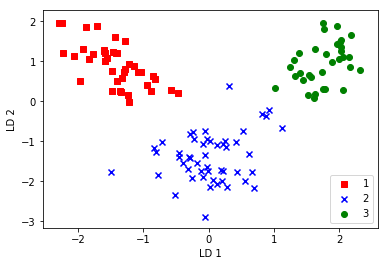

In [19]:
# Projecting samples onto the new feature space
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1] * (-1), c=c, label=l, marker=m)
    
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

## LDA via scikit-learn

Now, let's look at the LDA class implemented in scikit-learn:

In [8]:
# LDA via scikit-learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
lda.coef_

array([[ 2.4248e+00, -2.3695e-01,  1.1333e+00, -2.1404e+00,  3.4789e-01,
        -1.6836e+00,  4.6958e+00,  6.2491e-01, -2.6667e-01, -1.8717e+00,
        -5.1262e-01,  2.6236e+00,  4.8543e+00],
       [-1.7951e+00, -7.8860e-01, -1.5198e+00,  1.3658e+00, -2.8126e-01,
         3.3542e-01,  1.2701e+00, -1.0387e-02,  3.1380e-01, -1.2003e+00,
         1.0646e+00, -2.2602e-01, -2.5704e+00],
       [-2.9280e-01,  1.4892e+00,  8.9477e-01,  5.8989e-01, -6.0718e-03,
         1.5835e+00, -7.7587e+00, -7.6067e-01, -1.4414e-01,  4.1442e+00,
        -9.7618e-01, -2.9172e+00, -2.1366e+00]])

/home/raziel/.virtualenvs/PythonMachineLearning/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


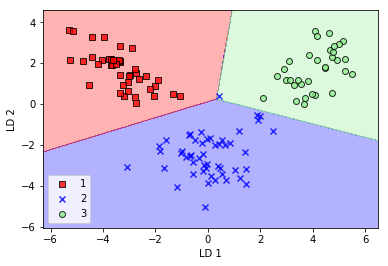

In [23]:
# ler's see how it works with logistic regression classifier
from sklearn.linear_model import LogisticRegression
from plot_regions import plot_decision_regions

lr = LogisticRegression(multi_class='auto')
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

By lowering the regularization strength, we could probably shift the decision boundaries so that the logistic regression model classifies all samples in the training dataset correctly. However, and more importantly, let us take a look at the results on the test set:

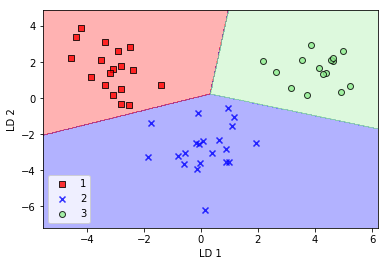

In [24]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()